In [1]:
%matplotlib inline
#from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl
import pickle as pkl

In [12]:
def readDat(files, path, time_zone, from_wrf = True):
    """
    Read time series csv files for each station code from a specific path
    
    Parameters
    ----------
    files : str list
        name of csv files
    path  : str
        path location
    time_zone : str
        for instance 'America/Sao_Paulo'
    
    Returns
    -------
    Pandas DataFrame
    """
    Data = pd.DataFrame()
    
    if from_wrf:
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
        Data.loc[:,'local_date']=Data['date'].dt.tz_convert(time_zone)
        return Data
    
    else: # observations
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
        Data.rename(columns={'date':'local_date'}, inplace = True)
        Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
        return Data

def subplots_rcp(df,pol,ylabel,xlabel,suffixes,legend, legend_size, hspace,
                 size, n_yticks, n_xticks,filename,alpha,lw,markersize,labelsize, by):
    """
    Return lineplot subplots by station only completed data to be compared.
    
    Parameters
    ----------
    df       : pandas DataFrame with datetime as index
               time series with colnames as station and meteorological and air quality parameters
    pol      : str
               air quality parameter, for instance, pol = 'o3'
    ylabel   : str
    xlabel   : str
    suffixes : list of two strings, for instance suffixes = ['_rcp45','_rcp85']
    legend   : list of three strings
    leg_size : int
    hspace   : float
    size     : tuple, default size = (6,8)
    n_yticks : int
               Number of yaxis labels
    n_xticks : int
               Interval number of xaxis labels               
    path     : str
               path location where the figure will be located
    name     : str
               suffix name of figure
    alpha    : float between 0 and 1. Default 0.7
    lw       : int
    markersize : int
    labelsize : int
    by       : str
               subplots by specific name based column names
    
    Returns
    -------
    Figure exported as pdf plot in a specific path
    
    """
    df_1 = df[[by,pol,pol+suffixes[0],pol+suffixes[1]]].dropna()
    locs = list(df_1.sort_values(by=by,ascending=True)[by].unique()) 
    
    fig, ax = plt.subplots(df_1[by].nunique(),
                           figsize=size, 
                           sharex=True, sharey=True,
                           gridspec_kw={'hspace':hspace})
    for i in range(df_1[by].nunique()):
        df_1.loc[df_1[by] == locs[i]][pol].\
        plot(ax=ax[i],color='g', marker='.',linestyle='none',
             markersize=markersize, label=legend[0])
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[0]].\
        plot(ax=ax[i],color='c', linestyle='-',lw=lw, alpha=alpha, label=legend[1]) #86B2D6
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[1]].\
        plot(ax=ax[i],color='#D22523', linestyle='-',lw=lw, alpha=alpha, label=legend[2])
        ax[0].xaxis.set_major_formatter(md.DateFormatter('%d'))
        ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,n_xticks)))
        ax[0].xaxis.set_minor_locator(md.MonthLocator())
        ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n%b'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[i].tick_params(axis='both', which='minor', labelsize=labelsize)
        ax[i].tick_params(axis='both', labelsize=labelsize)
        ax[2].set_ylabel(ylabel)
        ax[i].set_xlabel(xlabel)
        ax[i].set_title(locs[i],size=8, loc='left')
        if i == len(df_1[by].unique())-1:
            ax[i].legend(fontsize=legend_size)
    fig.savefig(filename+'_subplot_'+pol+'.pdf',bbox_inches='tight', facecolor='w')

# Changes in Surface O$_3$

Two emission scenarios RCP4.5 and RCP8.5 as meteorological initial and boundary conditions in the WRF-Chem model was obtained from NCAR CESM Global Bias-Corrected (ds316.1). These datasets have one degree of spatial resolution every six hours. Emission files entered to WRF-Chem were the same information used to simulate September 2018. So, only meteorology IC/BC used are different of the modelling done for the control-case simulation (September, 2018). WRF-Chem results correspond to all hours of September 2030 and covers the same stations analyzed in modelling results for September 2018.

In [3]:
stations = pd.read_csv('../1_ObsData/stations.csv')
not_stations = ['Santos',
                'Santos-Ponta da Praia',
                'Cubatão-Centro',
                'Cubatão-Vale do Mogi',
                'Cubatão-V.Parisi']
stations = stations.loc[(~stations.name.isin(not_stations)) & \
                        (stations.domain =='d02')]\
            .drop('domain', axis=1).sort_values(by='code')
stations.index =stations.code
stations.head()

,name,lat,lon,code,type,abb
code,,,,,,
0,IAG,-23.651200,-46.622400,0,Forest preservation,IAG
63,Santana,-23.505993,-46.628960,63,Urban,Stna
64,Santo Amaro,-23.654977,-46.709998,64,Urban,SAm
65,Mauá,-23.668549,-46.466000,65,Urban,Maua
67,Sorocaba,-23.502427,-47.479030,67,Regional urban,Srcb


We import data for modelling simulations corresponds to September, 2018 and emission scenarios RCP4.5 and RCP8.5 for year 2030. According to suggestions of Ritter (2013), modelling run was set-up with reinitialization and one day of spin-up.

In [5]:
# Import and modelling results
filename = 'data/Mod_data.pkl' # as pandas DataFrame

if os.path.exists(filename) is False:
    # Sep. 2018 (Control-case)
    Dir = '../3_Results/SEP18/wrfout_exp10/'
    f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')

    sep18 = readDat(f18, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    sep18.rename(columns={'name':'station'})
    sep18 = sep18[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    sep18['nox'] = sep18.no+sep18.no2
    sep18['Mday']= sep18.local_date.dt.strftime('%b-%d-%H')
  
    # Sep. 2030 (RCP4.5):
    Dir = '../3_Results/RCP4.5/wrfout_exp10/'
    f30_rcp45 = fnmatch.filter(os.listdir(Dir), '*rcp45*')
    rcp45_30  = readDat(f30_rcp45, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    rcp45_30.rename(columns={'name':'station'})
    rcp45_30 = rcp45_30[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    rcp45_30['nox'] = rcp45_30.no+rcp45_30.no2
    rcp45_30['Mday']= rcp45_30.local_date.dt.strftime('%b-%d-%H')
    
    # Sep. 2030 (RCP8.5):
    Dir = '../3_Results/RCP8.5/wrfout_exp10/'
    f30_rcp85 = fnmatch.filter(os.listdir(Dir), '*rcp85*')
    rcp85_30  = readDat(f30_rcp85, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    rcp85_30.rename(columns={'name':'station'})
    rcp85_30 = rcp85_30[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    rcp85_30['nox'] = rcp85_30.no+rcp85_30.no2
    rcp85_30['Mday']= rcp85_30.local_date.dt.strftime('%b-%d-%H')
    
    # Merge data
    by = ['Mday','station','code','type']
    Mod = rcp45_30.merge(rcp85_30,on=by,suffixes=('_rcp45', '_rcp85')).merge(sep18, on=by)
        
          # to pickle
    Mod.to_pickle(filename)
else:
    Mod = pd.read_pickle(filename)
    #Obs_dic = pkl.load(open(fname_1, "rb"))
    #Mod_dic = pkl.load(open(fname_2, "rb"))

# Rolling 8 hour mean
o3 = Mod[['local_date','station','type', 'o3','o3_rcp45','o3_rcp85']].set_index('local_date')
roll_o3 = {}
rollo3 = pd.DataFrame()
for i in o3.station.unique():
    roll_o3[i] = (o3[o3.station == i].rolling(window=8).mean()[['o3','o3_rcp45','o3_rcp85']])
    roll_o3[i]['station'] = i
    roll_o3[i]['type'] = (o3[o3.station == i].type)
    df = roll_o3[i]
    rollo3 = pd.concat([rollo3,df])
    rollo3['day'] = rollo3.index.day
    MDA8 = rollo3.groupby(['day','station','type']).max().reset_index().dropna()
    
types = list(MDA8.sort_values(by='type',ascending=True).type.unique())


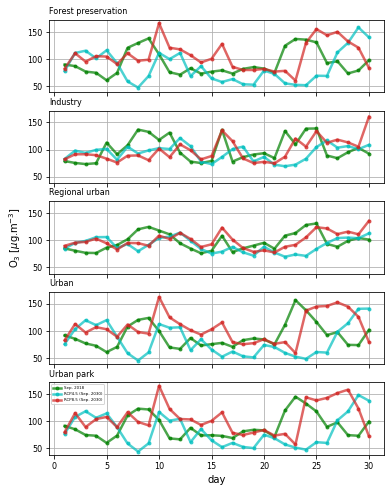

In [30]:
fig, ax = plt.subplots(len(types),
                       figsize=(6,8),
                       sharey=True,
                       sharex=True,
                       gridspec_kw={'hspace':0.25})
for i in range(len(types)):
    MDA8.loc[MDA8.type ==types[i]].groupby(['type','day'])\
    .mean().reset_index().set_index('day')\
    .plot(ax=ax[i], legend=False, grid=True, fontsize=8,
          color=['g','c','#D22523'], lw=2.5, marker='.', alpha=.7)
    ax[i].set_title(types[i],size=8, loc='left')
    ax[2].set_ylabel('O$_3$ [$\mu$g.m$^{-3}$]')
    if i == len(types)-1:
        ax[i].legend(['Sep. 2018','RCP4.5 (Sep. 2030)','RCP8.5 (Sep. 2030)'],fontsize=4)
fig.savefig('../4_Draft_Report/Dissertation/fig/MDA8_type_rcps.pdf',bbox_inches='tight', facecolor='w')

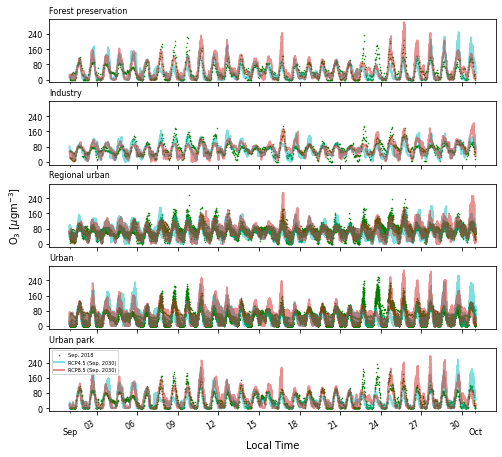

In [17]:
subplots_rcp(Mod.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_rcp45','_rcp85'],
         legend=['Sep. 2018','RCP4.5 (Sep. 2030)','RCP8.5 (Sep. 2030)'],
         legend_size=5,
         size=(8,8),
         hspace=0.3,
         n_yticks=5,
         n_xticks=3,
         filename='../4_Draft_Report/Dissertation/fig/rcp_2030',
         alpha=.5,
         markersize=1,
         lw=2,
         labelsize=8, 
         by='type')

In [18]:
Mod.groupby(['station']).mean()[['tc','tc_rcp45','tc_rcp85']].index.nunique()

57

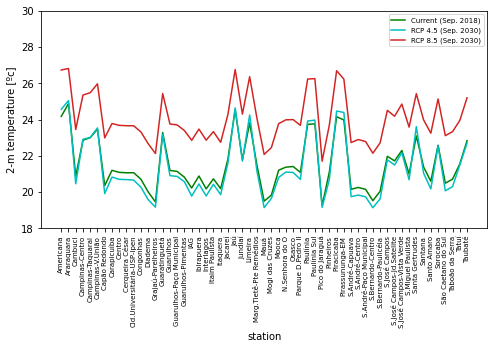

In [19]:
import matplotlib.ticker as plticker
fig, ax = plt.subplots(figsize=(8,4))
plot_1 = Mod.groupby(['station']).mean()[['tc','tc_rcp45','tc_rcp85']]
plot_1.plot(rot=90,color=['g','c','#D22523'], ax=ax)
ax.legend(['Current (Sep. 2018)','RCP 4.5 (Sep. 2030)','RCP 8.5 (Sep. 2030)'], fontsize=7)
ax.set_ylabel('2-m temperature [ºc]')
xtick_labels = list(plot_1.index)
ax.set_xticks(range(len(xtick_labels)))
ax.set_xticklabels(xtick_labels, rotation='vertical', fontdict={'fontsize':7})
ax.set_ylim(18,30)
fig.savefig('../4_Draft_Report/Dissertation/fig/temp_sep.pdf',bbox_inches='tight', facecolor='w')

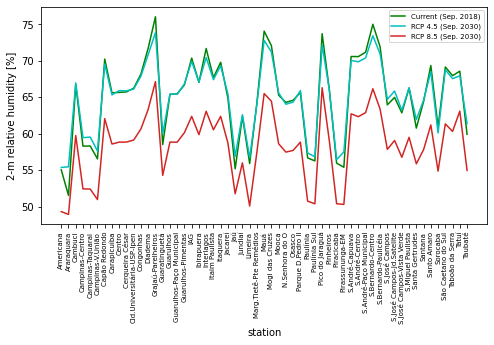

In [20]:
import matplotlib.ticker as plticker
fig, ax = plt.subplots(figsize=(8,4))
plot_1 = Mod.groupby(['station']).mean()[['rh','rh_rcp45','rh_rcp85']]
plot_1.plot(rot=90,color=['g','c','#D22523'], ax=ax)
ax.legend(['Current (Sep. 2018)','RCP 4.5 (Sep. 2030)','RCP 8.5 (Sep. 2030)'], fontsize=7)
ax.set_ylabel('2-m relative humidity [%]')
xtick_labels = list(plot_1.index)
ax.set_xticks(range(len(xtick_labels)))
ax.set_xticklabels(xtick_labels, rotation='vertical', fontdict={'fontsize':7})
#ax.set_ylim(18,30)
fig.savefig('../4_Draft_Report/Dissertation/fig/rh_sep.pdf',bbox_inches='tight', facecolor='w')

## Spatial Variation 

In [22]:
from mpl_toolkits.basemap import Basemap

In [23]:
o3_mean = MDA8.groupby('station').mean().reset_index().drop('day',axis=1)
o3_mean['lat'] = [stations[stations.name == i].lat.values[0] for i in o3_mean.station]
o3_mean['lon'] = [stations[stations.name == i].lon.values[0] for i in o3_mean.station]
o3_mean


,station,o3,o3_rcp45,o3_rcp85,lat,lon
0,Americana,104.426142,100.268999,106.570901,-22.724253,-47.339549
1,Araraquara,85.269400,83.041666,88.702484,-21.782522,-48.185832
2,Cambuci,88.538488,79.409461,105.540329,-23.567708,-46.612273
3,Campinas-Centro,98.675652,92.093886,102.168822,-22.902525,-47.057211
4,Campinas-Taquaral,99.517922,92.106484,101.517936,-22.874619,-47.058973
5,Campinas-V.União,104.416458,99.846873,109.283489,-22.946728,-47.119281
6,Capão Redondo,91.851660,84.760060,106.009801,-23.668356,-46.780043
7,Carapicuíba,98.273136,89.300266,104.349334,-23.531395,-46.835780
8,Centro,88.148493,78.383338,103.241788,-23.547806,-46.642415
9,Cerqueira César,91.549988,81.079400,105.632932,-23.553543,-46.672705


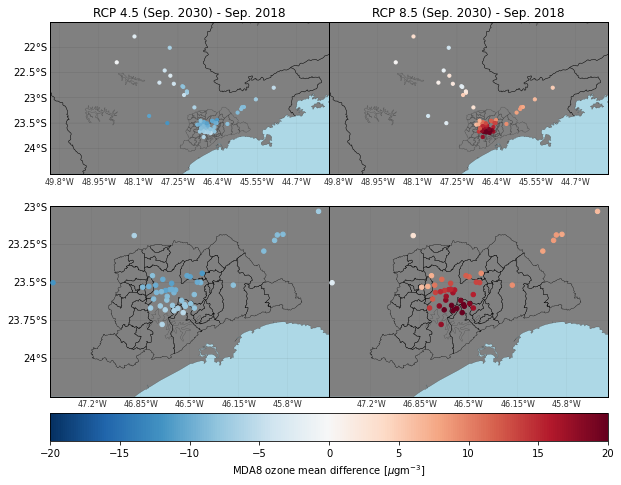

In [33]:
diff = {'RCP 4.5 (Sep. 2030) - Sep. 2018':o3_mean.o3_rcp45.values - o3_mean.o3.values,
        'RCP 8.5 (Sep. 2030) - Sep. 2018':o3_mean.o3_rcp85.values - o3_mean.o3.values}

min_v = -20
max_v = 20
fig, ax = plt.subplots(2,2, figsize=(10,10),gridspec_kw={'hspace':0.0,'wspace':0})
res = 'h'
for i, d in enumerate(diff):
    m = Basemap(projection='merc',llcrnrlon=-50,llcrnrlat=-24.5,
                urcrnrlon=-44,urcrnrlat=-21.5, resolution=res, ax=ax[0,i])
    m.drawcoastlines(color='0.2',linewidth=0.2)
    m.drawstates(color='k',linewidth=0.5)
    m.drawmapboundary(fill_color='lightblue')
    if i ==0:
        m.drawparallels(np.arange(-60, 0, 0.5),linewidth=0.05,labels=[1,0,0,0])
    m.drawparallels(np.arange(-60, 0, 0.5),linewidth=0.05,labels=[0,0,0,0], fontsize=8, alpha=0.8)
    m.drawmeridians(np.arange(-60, 0, 0.85),linewidth=0.05, labels=[0,0,0,1], fontsize=8, alpha=0.8)
    m.fillcontinents(color='0.5',lake_color='0.5')
    m.readshapefile("../3_Modeling/MunRM07",'sp', drawbounds=True, color='0.3',
                default_encoding='ISO-8859-1',linewidth=0.3)

    cb = m.scatter(o3_mean.lon.values, o3_mean.lat.values, marker='o',vmin=min_v,vmax=max_v,
          latlon=True,c=diff[d], cmap='RdBu_r', alpha=1, s = 10,zorder=100)
    ax[0,i].set_title(d)
    
    m = Basemap(projection='merc',llcrnrlon=-47.5,llcrnrlat=-24.25,
                urcrnrlon=-45.5,urcrnrlat=-23, resolution=res, ax=ax[1,i])
    m.drawcoastlines(color='0.2',linewidth=0.2)
    m.drawstates(color='k',linewidth=0.5)
    m.drawmapboundary(fill_color='lightblue')
    if i ==0:
        m.drawparallels(np.arange(-60, 0, 0.25),linewidth=0.05,labels=[1,0,0,0])
    m.drawparallels(np.arange(-50, 0, 0.25),linewidth=0.05,labels=[0,0,0,0], fontsize=8, alpha=0.8)
    m.drawmeridians(np.arange(-50, 0, 0.35),linewidth=0.05, labels=[0,0,0,1], fontsize=8, alpha=0.8)
    m.fillcontinents(color='0.5',lake_color='0.5')
    m.readshapefile("../3_Modeling/MunRM07",'sp', drawbounds=True, 
                default_encoding='ISO-8859-1',linewidth=0.3)

    cb = m.scatter(o3_mean.lon.values, o3_mean.lat.values, marker='o',vmin=min_v,vmax=max_v,
          latlon=True,c=diff[d], cmap='RdBu_r', alpha=1, s = 20,zorder=100)    
    
fig.colorbar(cb,label='MDA8 ozone mean difference [$\mu$gm$^{-3}$]',orientation='horizontal',ax=ax,pad=0.03)
fig.savefig('../4_Draft_Report/Dissertation/fig/MDA8_spatial_station.pdf',bbox_inches='tight', facecolor='w')
